In [10]:
import numpy as np
import time
import os
import matplotlib.pyplot as plt 
from Queue import PriorityQueue
import a_star
reload(a_star)

<module 'a_star' from 'c:\Users\herbi\Documents\Spring 2022\6141\racecar_docker\home\racecar_ws\src\path_planning\src\a_star.py'>

In [2]:
occupancy_grid_ex_1 = np.array([
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0],
    [0,0,1,0,0,1,0,0,0,0],
    [0,0,1,0,0,1,0,0,0,0],
    [0,0,1,0,0,1,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,1,0,0],
    [0,0,1,0,0,0,0,1,0,0]
    ])
occupancy_grid_ex_2 = np.array([
    [0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0],
    [0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0],
    [0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0],
    [0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0],
    [0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0],
    [0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0],
    [0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0],
    [0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0],
    ])

In [3]:
def plan_path(map, start, goal, visualize=True):
    planner = a_star.AStarPlanner(map.flatten(),map.shape[0],map.shape[1],1)
    path = planner.find_path(start, goal)
    if visualize:
        plt.figure()
        map[start] = 2
        map[goal] = 3
        plt.imshow(map)
        plt.figure()
        for point in path:
            map[point] = 4
        plt.imshow(map)
        plt.show()



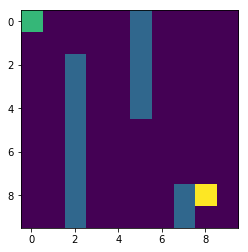

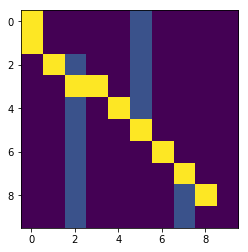

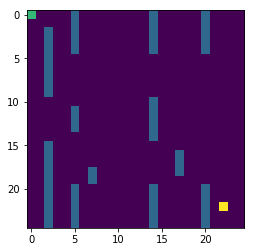

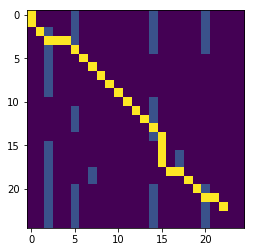

In [4]:
plan_path(occupancy_grid_ex_1.copy(), (0,0), (8,8))
plan_path(occupancy_grid_ex_2.copy(), (0,0), (22,22))

(600, 350)


KeyError: (1000, 350)

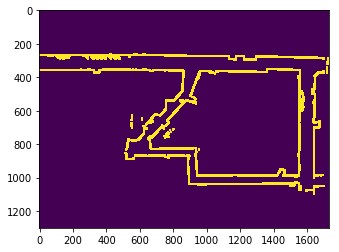

In [11]:
data = np.load('dilated_map.npy')
stata_basement_map = np.reshape(data, (1730, 1300),'F')
stata_basement_map = np.rot90(stata_basement_map)

plt.imshow(stata_basement_map)
plan_path(stata_basement_map, (600, 320), (1000,320), 1)